In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Libraries

In [2]:
!pip install transformers
!pip install syllabipy

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 61 kB 462 kB/s 
     |████████████████████████████████| 895 kB 34.0 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 3.3 MB 49.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for syllabipy: filename=syllabipy-0.2-py3-none-any.whl size=5813 sha256=d66d221d7bb799b061a4430eebde968b386f346c24c554344f072437627a7de7
  Stored in directory: /root/.cache/pip/wheels/5a/43/1a/9078e0df36fa76df8c584c20b0eeb924ad8686d240b1a9646a
Successfully built syllabipy


In [3]:
import numpy as np
import pandas as pd

import random
import time
import datetime

import torch
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm

from syllabipy.sonoripy import SonoriPy

from tokenizers import ByteLevelBPETokenizer
from tokenizers import BertWordPieceTokenizer

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer

# Train Tokenizer

In [4]:
# Train tokenizer

paths = ["/content/gdrive/MyDrive/pr/limericks_end_with_[SEP]_sep_with_-_and_$.txt"]
# paths = ["/content/gdrive/MyDrive/pr/limricks_end_with_[SEP]_sep_with_-.txt"]

# Initialize a tokenizer
tokenizer = BertWordPieceTokenizer()

special_tokens=['[SEP]', '-', '$']
print(special_tokens)

# Customize training
tokenizer.train(files=paths, vocab_size=20_000, min_frequency=2, special_tokens=special_tokens)

# special_tokens_dict = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'pad_token': '<PAD>'}
# tokenizer.add_special_tokens(special_tokens_dict)

# Save files to disk
tokenizer.save_model("/content/gdrive/MyDrive/pr/tokenizers", "tokenizerSyllables")

['[SEP]', '-', '$']


['/content/gdrive/MyDrive/pr/tokenizers/tokenizerSyllables-vocab.txt']

# Load Data

In [5]:
poem_df = pd.read_csv("/content/gdrive/MyDrive/pr/limericks_end_with_[SEP]_sep_with_-_and_$.txt", header=None)
poem_df = poem_df.fillna("")
print(poem_df)

                                                       0
0      capn $ jack $ was $ was hed $ o ver $ the $ si...
1      as $ a $ soup $ bis que $ is $ best $ when $ s...
2      sim ply $ add $ to $ the $ grasp $ of $ a $ rh...
3      a beds $ whe re $ yo u $ sleep $ in $ the $ ni...
4      a $ smi ling $ yo ung $ fel low $ from $ spain...
...                                                  ...
88507  the $ sto rys $ in $ front $ of $ our $ no ses...
88508  un ders tan ding $ the $ bi ble $ is $ hard - ...
88509  di ver ti cu la $ ma king $ yo u $ sick $ yo u...
88510  un $ bal lo $ in $ masc he ra $ what - is $ th...
88511  i $ said $ joe $ dad dy $ thinks $ that $ yo u...

[88512 rows x 1 columns]


# Hyperparameters

In [6]:
batch_size = 16
epochs = 40
max_len = 100
device = torch.device('cuda')
learning_rate = 1e-4
eps = 1e-8
random_seed = 73
warmup_steps = 50

In [9]:
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [10]:
tokenizer = BertTokenizer.from_pretrained("/content/gdrive/MyDrive/pr/tokenizers/tokenizerSyllables-vocab.txt")
print("len(tokenizer) = ", len(tokenizer))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1645: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  FutureWarning,
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer) =  15114


# Dataset

In [11]:
class PoemDataset(Dataset):
    
    def __init__(self, data, tokenizer, max_length=max_len):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        encodings_dict = self.tokenizer(self.data[idx],
                                        truncation=True,
                                        max_length=self.max_length,
                                        padding='max_length'
                                        )
        input_ids = torch.tensor(encodings_dict['input_ids'])
        attention_mask = torch.tensor(encodings_dict['attention_mask'])
        return input_ids, attention_mask

poem_dataset = PoemDataset(poem_df.iloc[:, 0].values, tokenizer, max_len)

# Dataloader

In [12]:
poem_dataloader = DataLoader(poem_dataset, batch_size=batch_size)

In [13]:
max_poem_length = max([len(tokenizer.encode(poem)) for poem in poem_df.iloc[:, 0].values])

In [14]:
a = [len(tokenizer.encode(poem)) for poem in poem_df.iloc[:, 0].values]

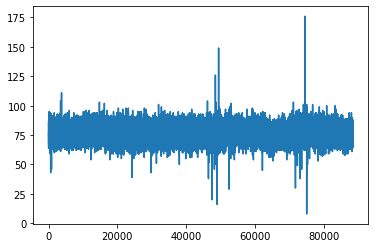

In [15]:
import matplotlib.pyplot as plt
plt.plot(a)

# Model Definition

In [28]:
configuration = GPT2Config(vocab_size=15113, n_positions=max_len)
poem_model = GPT2LMHeadModel(config=configuration)

poem_model.resize_token_embeddings(15113)

optimizer = AdamW(poem_model.parameters(), lr=learning_rate, eps=eps)

total_steps = len(poem_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

poem_model = poem_model.to(device)

print(poem_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(15113, 768)
    (wpe): Embedding(100, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
 

In [33]:
def generate_poems(poem_model):
    prompt = "[CLS]"
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    poem_model.eval()
    sample_outputs = poem_model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length=max_len,
                                    top_p=0.95, 
                                    num_return_sequences=50
                                    )

    for i, sample_output in enumerate(sample_outputs):
        sample_output = tokenizer.decode(sample_output, skip_special_tokens=True)
        sample_output = sample_output.replace(" ", "").replace("$", " ").replace("-", " - ")
        print("{}: {}\n\n".format(i, sample_output))

In [36]:
model_weights_file = '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch20.pth'
poem_model.load_state_dict(torch.load(model_weights_file))

generate_poems(poem_model)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: dgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsia - and pos posed politically gee - she or she - or the red bottom three - and four sizes the end of a tree - dgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsia


1: dgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsia - atisms posing progress - trickc - trick in light  - matter stayed  - in a country  but  - dgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsia


2: dgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsiadgrnsia - is a point in syd

In [ ]:
model_weights_file = '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch24.pth'
poem_model.load_state_dict(torch.load(model_weights_file))

for epoch in range(25, epochs):

    print(f'Epoch {epoch + 1} of {epochs}')

    total_train_loss = 0
    poem_model.train()

    with tqdm(poem_dataloader) as t:
      for step, batch in enumerate(t):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                            labels=b_labels,
                            token_type_ids=None,
                            attention_mask=b_masks)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    if (epoch % 2 == 0):
        torch.save(poem_model.state_dict(), '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch%d.pth' % epoch)

    generate_poems(poem_model)

Epoch 26 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.614098059704402.
0:  - nose that oupaths with a baghouse in africa wa thats - the cindering trail - is a tree line in jail - and a volkswagen called a bahrain - 


1:  - us cause many a thought made allogrope lines and limes for dimension - but with  traffic a state - at each peak of it ate - so its presence a greater invention - 


2:  - to the power in hot sea the stockstry as zero and then - and then seated to me - hot or thin time  - you will hear it the weather and then - 


Epoch 27 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]


Average Training Loss: 0.5968035563007698.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - a laugh neither odd common life nor a gardener if one of them - nor on top at the bottle - when ladence grows nicked up to bristle - 


1:  - to islam in an august adhered degrees that beguiles - the nation called delos  - in a force called a crosux name to the angle for miles - 


2:  - as the guy travels back to the hills it would seem out to be - put a quick fuel in there - the guy first called his hair - to the ocean but angel in time - 


Epoch 28 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.5619907823599342.
0:  - a feeling of absence a letter of measure was key - to force that his musell - was bound to impusel - to lure the best weapon to be - 


1:  - no sales wither and nother parental mordan - but youre stillbedent chaste - it just means to be faced - by its monikerhen ahgrah yawn - 


2:  - to your permit with friendships and directness youre here on the doubled - you bring womens and beer - just a bank bank and stay the wife cheerled at the deed that you spockd - 


Epoch 29 of 40


100%|██████████| 5532/5532 [20:08<00:00,  4.58it/s]


Average Training Loss: 0.5273029319645698.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - hinghe desperally three - the first alporget spurned - is a second and dart  - he is just what will get there we see - 


1:  - to your perfect devotion a fort would improve you pollute  - with a deprehension - decontrolling your dmission for free - 


2:  - that judge wrong is a time before one performers the sort o the same - mark it out on the wane - by a bell that is lane - it is left on the right side of fame - 


Epoch 30 of 40


100%|██████████| 5532/5532 [20:08<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.49508916699769956.
0:  - no office as viewing points is the past points to link - a bird maybe lining - but genius defining - the dialog blessing by praf - 


1:  - no that trons not the hell of a play to make music go real - but when viewed from a drumming - a playmate is coming - a serious lifetime move slow - 


2:  - no office is a leader whose leader passes are free  - when the negative factor - wont bend to the actor  - or cobac computers the key - 


Epoch 31 of 40


100%|██████████| 5532/5532 [20:08<00:00,  4.58it/s]


Average Training Loss: 0.465505482560254.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - has the cards that are stable we feathers but oh what can that - is the tensions on two - in the front one or two - we have only an arm like a hat - 


1:  - that seldom is benzonium sort of a braiding idea - you should know in the last  - to become water past - it got fenway wowers  uh dear - 


2:  - animal is a substance thats cardinal use of a word - circulation loobai - or some solids pursue - or formation you need some asses - 


Epoch 32 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.43932057506608857.
0:  - is a port one way to score in the meadow  thats all that we need - for next come of a sort - such a bold glass of sand - and an elder we call it the deed - 


1:  - is a doubleed obtusion for mercury contacts to poo - with its leatherworks made - if youre trying to fade  - for propelling the steamharding step - 


2:  - is in far than a land in the sea its bwire and not fleeting - this champagne by jurists  - points the whole world and use tourists sea the whole world - 


Epoch 33 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]


Average Training Loss: 0.4158009752868227.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - an aeronaut said im a threat to retrachave a selfherinlaws missed - as a climax so small - as that records your wall  - dockodiliance is on a list - 


1:  - all in space in the pace of your life is a life that we see - just be certain that this - depends on the norms  - and we will as well do some on  - 


2:  - is defined as the area  this every  - on a chart for a word  - the example are  - but in german theyre in for a  - 


Epoch 34 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.3944892650678894.
0:  - of distance has gliped a solution thats clear salutation - and thats on a matter - its a complex sour matter  - a small one of quasimodation - 


1:  - as the path of a graph that was partially bound for the pound - cross the phone  the deep bell  - called a fun point of gas  - a new ship for the pleasures a mound - 


2:  - as a noun its precise though most equalized is in its way - give a few minutes  wait - should a row in the gate - make a contract a penny bouquet - 


Epoch 35 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]


Average Training Loss: 0.37545887126020994.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - caused a patternspace left by celli they called me a gal - but oh tell by the two  - they wrote bridges for you - for similar thinkers for square - 


1:  - has increases a form that envelops a series of me - this ace denotes - some duration of motes - when its melodynamers agree - 


2:  - caused my fonsals a nobraidy level a meeting that fell - to the trunk of my fort - its predestined a fort - and a life zigzagged flat on the heel - 


Epoch 36 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.35751266578725516.
0:  - as the zone shows on screen in the spring are all wet - and a staple is nice - cause its acting the dice - it supports that a stone youll keep wet - 


1:  - to the ponymous forcestorthe organ for handplay for jay - for productions galore - and the code is a chore  - a small graphic if solemnbag on - 


2:  - to the pole an organ i hold the occasion today - it also is spurned - a free to be spurned - but the cost is the cantors toupee - 


Epoch 37 of 40


100%|██████████| 5532/5532 [20:10<00:00,  4.57it/s]


Average Training Loss: 0.34173599912886676.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - to the pose they ascend or announce you might note the land piece of joy - theyre a lifetime campaign - for the sergeant or house  - so the buildings wont stray such a joy - 


1:  - that goes northeast an egyptian a curve we call owker is rollin - instead the declivity - of manifold vivity - penning through line in and on - 


2:  - that happens a generalization is clearly his trail - he partrols his position - of throbmy ambition - a nearly sublime job in jail - 


Epoch 38 of 40


100%|██████████| 5532/5532 [20:10<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.3266299811157513.
0:  - to a promise the body where babies are  there are places - as the views been well swung - and it acts like a boulder  - bring a photo to corking in cases - 


1:  - to the pose an aquarium bore if you please - it will still have the worth - to have plenty of worth - for these buildings though not what you need - 


2:  - has a proton thats marked for a cord or a cord or a cord - a papaya is never - for soup and whatever - the purpose where hottone is stowed - 


Epoch 39 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]


Average Training Loss: 0.31298809772490677.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - has one student youre driving you maybe some day - but i know that youll find - you can tell whos been blind - to be aimless since driving your pay - 


1:  - no one said twos hypocrites to oe credit ct - with legume combined - it will leave the words fined - and be used to write etext for  - 


2:  - has one student like it luchered to do with to be - an ogre is locked - in all candle  youlllacked - that a column is what you will see - 


Epoch 40 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.30033852296544.
0:  - hausciengand thought he was doing the pyrite in rioja syrin - when plasma declined - with the popular mind - he wont need a few more than toes in - 


1:  - may i ask myself per select expertise  yes they cant - and get tongued in my gut - its as thick as old cut - but its better to quit or i shant - 


2:  - may educify that is your creed or maybe explained  - plastic surgery go up - and the rest may be low  - or accept your surmise bestlaid is on - 




In [ ]:
model_weights_file = '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch39.pth'
poem_model.load_state_dict(torch.load(model_weights_file))

for epoch in range(40, 60):

    print(f'Epoch {epoch + 1} of {epochs}')

    total_train_loss = 0
    poem_model.train()

    with tqdm(poem_dataloader) as t:
      for step, batch in enumerate(t):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                            labels=b_labels,
                            token_type_ids=None,
                            attention_mask=b_masks)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    if (epoch % 2 == 0):
        torch.save(poem_model.state_dict(), '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch%d.pth' % epoch)

    generate_poems(poem_model)

FileNotFoundError: ignored

In [ ]:
for epoch in range(epochs):

    print(f'Epoch {epoch + 1} of {epochs}')

    total_train_loss = 0
    poem_model.train()

    with tqdm(poem_dataloader) as t:
      for step, batch in enumerate(t):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                            labels=b_labels,
                            token_type_ids=None,
                            attention_mask=b_masks)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    if (epoch % 2 == 0):
        torch.save(poem_model.state_dict(), '/content/gdrive/MyDrive/pr/models/model_weights_20211203_1_epoch%d.pth' % epoch)

    generate_poems(poem_model)

Epoch 1 of 40


100%|██████████| 5532/5532 [20:02<00:00,  4.60it/s]


Average Training Loss: 2.3383480161320707.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  - called a few situality - this issues someone should amaciously - 


1:  - us limerick and lines  whats the one - for reverse limericks taking the ro - this component is status - de your every debate from its none - 


2:  -  we must see  what could owe - weve i done so we dont do it owe - if i get a nice guy - ill be done in a guy - to discover myself i have none - 


Epoch 2 of 40


100%|██████████| 5532/5532 [20:05<00:00,  4.59it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.9064359486921922.
0:  -  - cerebral egyptians - and a mere guaranteed - but if god makes it simply not fat - 


1:  -  - determine about doubt - lifes the axis in ages - like a general cables - like the disease from a coper in trout - 


2:  -  means i cant do they laugh - with no difference youre likely to laugh - the original phrase - and your mind might produce - makes a name for a crime  what a laugh - 


Epoch 3 of 40


100%|██████████| 5532/5532 [20:05<00:00,  4.59it/s]


Average Training Loss: 1.768901414485057.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  -  - her artificial - is her magnettica -  -  - 


1:  -  - elicits an asian - the word that we call em - a distorte thats known as casset - 


2:  -  -  -  - 


Epoch 4 of 40


100%|██████████| 5532/5532 [20:04<00:00,  4.59it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.6675195074434825.
0:  -  - at times we all say -  -  - 


1:  -  - that he - evil writer means grievous - if his writing is free - 


2:  -  - her dila - 


Epoch 5 of 40


100%|██████████| 5532/5532 [20:04<00:00,  4.59it/s]


Average Training Loss: 1.5753043449537012.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  - bad harmful - youre simply comeful - so its sure to catch sue - 


1:  -  - derment eta - in gorilla colum - hes a hata dine ewe - 


2:  -  -  -  -  - 


Epoch 6 of 40


100%|██████████| 5532/5532 [20:04<00:00,  4.59it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.485956320879861.
0:  -           -          -     -    -    -      -      -  -  - 


1:  -  -  -  - 


2:  -  in its onefiftytwo  on the  - plus  a in  - a remote   - on the two  this is key - so its better than  - 


Epoch 7 of 40


100%|██████████| 5532/5532 [20:02<00:00,  4.60it/s]


Average Training Loss: 1.3986772626789257.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  made me think case for my job theres a thought - and ive never done less - than a crime i confess - that i never get even more old - 


1:  -  in this comical island america tends folded high - next its a game - so its once called  - it has been used by many a ly - 


2:  -  -   -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 


Epoch 8 of 40


100%|██████████| 5532/5532 [20:02<00:00,  4.60it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.3132911717663274.
0:  -  in a biay word - are the aqueoe  exceeded on day - this as    is a dit -  and    now youre all left to  - 


1:  -  edward  i saw     i signed the word ritane and then - his attrac  plated - the end was inflamed  with it faced - 


2:  -  -   then  adeno  ademoda    -        -  then  - 


Epoch 9 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]


Average Training Loss: 1.2304148357779068.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 


1:  -  - time for golf years when years come the year and  - a small metal will rise - and some others of size  - then a comedy makes me a fee - 


2:  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 


Epoch 10 of 40


100%|██████████| 5532/5532 [20:09<00:00,  4.57it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.1513878987672443.
0:  makes it my mind disembowel - since i lost it i thought myself foul - i gave it a glance - but its sinking him france - was it my brain id not been the belle - 


1:  -  feeling easy to do -  a few  then its you - douse on and a spare - has the meaningless there - the connects is the maze  todaystwo - 


2:   a small star in my class - im in trouble my hands on my ass - and to signal my face - on the couch in this place - the camels did last one more grass - 


Epoch 11 of 40


100%|██████████| 5532/5532 [20:14<00:00,  4.55it/s]


Average Training Loss: 1.0756083541453445.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  is the college degree - diplomari we call the degree - when the earth blows our course - then theres no way by force - what  go up to the  - 


1:  - hing ahista - 


2:  -  - toward tor - ordered his stagdry dispeein - 


Epoch 12 of 40


100%|██████████| 5532/5532 [20:12<00:00,  4.56it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.0046058224644767.
0:  - no matter how years appear on the slopes of creates of attacks - admiral and force - and estimate source - are more often able to pass - 


1:  - ing - mode sloped overrot  - with de courses to get a morose - 


2:  -  - gothroly distracting - with very sake laying by far - 


Epoch 13 of 40


100%|██████████| 5532/5532 [20:03<00:00,  4.60it/s]


Average Training Loss: 0.9369355240487914.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - a stance key and sank cargo shows dancing  - its grape delegation - denaturates the nation - of desequent dancing all through - 


1:  -  feelin  - sevense  - all are and  - hed to agree - for a habit or  - 


2:  -  is uk about time for american bott  when you rise - a renais in a mango - called amonga bingo - for what the motel has its prime  - 


Epoch 14 of 40


100%|██████████| 5532/5532 [19:58<00:00,  4.62it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.8738684200520802.
0:  -  - and dishinced to a nix - 


1:  -  feeler enthron had the point they were giving this free  - in defense it was heat - and it totally heat  - three electrons both total and free - 


2:  -  feeling scanty  this wee island is primed for it he - once in his own  - went kaput  a degree - since the law wasnt too hard to see - 


Epoch 15 of 40


100%|██████████| 5532/5532 [20:02<00:00,  4.60it/s]


Average Training Loss: 0.8153579482890865.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - no computerize life slipped the factors for humans to stray - but we gave her a shock - it was hard to enmock - something vital that filled the whole day - 


1:  - her computerized coursework is lost to the route of the attic - and now this guys meeting - far more than a meeting - shes hiding her multiple attic - 


2:  - on her donut i came up with a pin and i said you cant parlay - to the sutures in detail - without the event in her a - 


Epoch 16 of 40


100%|██████████| 5532/5532 [20:00<00:00,  4.61it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.7604503219089298.
0:  - nal leaders will not have a problem that makes them the key if i can - we know nation demand - when a manager and - a problem thus never run on - 


1:  - no the genius he just missed the horse with its head to its shore - was his backing at six - either stays there for kicks - for the angels or once he meant more - 


2:  - signed a germane thats no land at all that is neat - this dealers appalling - were leading the calling - for neighbors whose bank accounts neat - 


Epoch 17 of 40


100%|██████████| 5532/5532 [20:04<00:00,  4.59it/s]


Average Training Loss: 0.7101240567674434.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - an achievement was forced to another musician display - he informed the aroma - of blood in his coma - and now hes one suity vote stray - 


1:  - on her fur with hair silver with wideopen sole in a flan - not a name can improve - her octavia groove - with a lady that plays in her scan - 


2:  - on a tour that was planted a plea count to three do it well - this aboutface derived - to be clerkly derived - they were awed when the first one could tell - 


Epoch 18 of 40


100%|██████████| 5532/5532 [20:06<00:00,  4.59it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.6638490656203578.
0:  - no humor in her england in her game is her glibness or sepl - is no secret if i - know that which size her up to her  - 


1:  - the horseback is so awfully fated to be - the postwar an onus - they want to want so us - like beeshaped balls up to the  - 


2:  - a partially large outofbored bar eternally - for troops who have left - and work work till birthdayed - all over  but is that premie - 


Epoch 19 of 40


100%|██████████| 5532/5532 [20:06<00:00,  4.58it/s]


Average Training Loss: 0.6210013286076589.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - the audits for second runs all about about - in time here come on - are there standard i con - from the angular road to the wall - 


1:  - names for the coursest of a first class of phrase for the score - then the lenses here comes - for our own big small bums  - now a camp where theres no doubt to score - 


2:  -   bob cried theres the band runner club hed say - with kakwater remote - and with kaspaghes your vote - for the band games still no one will see - 


Epoch 20 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.5818483298583816.
0:  - hey - distracted hurquet for depras - he in de lites the katus - 


1:  - hey - hahaha dished rice - but that surely he died before - 


2:  - he lido - proposing decote - de derosed for a hell once mo - 


Epoch 21 of 40


100%|██████████| 5532/5532 [20:06<00:00,  4.58it/s]


Average Training Loss: 0.5461388838868683.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - let in a circles contract the state coming forward not far - but in physics authentic - its not quite simplistic - in fact that cause slips what they are - 


1:  - hey lilifa - ot denounce dawaitis scandal  - 


2:  - no mere gonners nor not information - nor stand fixing feathers not placid - but a pin on your door - will bring chemical more - make too many and bring you for acid - 


Epoch 22 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.5135578764407254.
0:  - that hap in the enemy prints but they cant go too few - wed greatly decide  - in the alpha or tide - for the romans our candles was through - 


1:  - time is good for the clap or the crap that i pay - but the president will - in the core guaranteed - seven minutes will fill your own pay - 


2:  - may be formally done by design for the poor personnel - if she isnt a breeze - but we soon may be these - and the blue things in common they chew - 


Epoch 23 of 40


100%|██████████| 5532/5532 [20:06<00:00,  4.58it/s]


Average Training Loss: 0.4835349628062069.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - such glamorous daily compounded heres proof that slur boil  - weve invested the gorilla - weve seved through the cella - prepading for each govern spoon - 


1:  - of these ciliarettes inites barren airplanes will pay - it arrives during surging - and wont sport male urging - but meslands the best you can say - 


2:  - its gonna be guided a pleasant belowdecks a quay - with your assets dilated - lest anything sated - as brother be signed to paris - 


Epoch 24 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.4563585552868426.
0:  - to a public indecent integration is run - the etuice ration - and baution that motion - on your sole move of the time youll be out there i cry me - 


1:  - on her toes an armatment shell bon you a dollar  a pin name should do - she declares that a fire  - a big pink would suffer higher - a condiment not for a gourd - 


2:  - a for artemis for your poppy a trip to the peak isnt flat - this antepen goes - by adhesive repose - try a load for the left blower hat - 


Epoch 25 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]


Average Training Loss: 0.4315805802537924.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - every year in new york you can only be sure to assure - that well also are right - you wont to come in white - as our queues work is duly impure - 


1:  - he onic demonic - and despubes that were dead - but depucedly said - it was securate go its a goner - 


2:  - its exequia kindle of base for the champion sir but the horse - of the wedding runs turn - with a corsairs to burn - as round here to be filled with remorse - 


Epoch 26 of 40


100%|██████████| 5532/5532 [20:07<00:00,  4.58it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.4085846779166316.
0:  - has increased her suspensesitters buddle thats me - said the color named stone - cast her navel alone - im so glad i can sleep with this  - 


1:  - to the pose for performers in the morgate  - a fortress for one - like the englishmans son - and the answers the smallest boo - 


2:  - time is second  best not so forcing a friend of a friend - but for favor the crew - who will bring you a few - one who cares a nostalgic bond end - 


Epoch 27 of 40


  1%|          | 32/5532 [00:06<20:07,  4.56it/s]

In [ ]:
# model_weights_file = '/content/gdrive/MyDrive/pr/model_weights_20211128_1_epoch13.pth'
# poem_model.load_state_dict(torch.load(model_weights_file))

for epoch in range(epochs):

    print(f'Epoch {epoch + 1} of {epochs}')

    total_train_loss = 0
    poem_model.train()

    with tqdm(poem_dataloader) as t:
      for step, batch in enumerate(t):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                            labels=b_labels,
                            token_type_ids=None,
                            attention_mask=b_masks)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    if (epoch % 2 == 0):
        torch.save(poem_model.state_dict(), '/content/gdrive/MyDrive/pr/model_weights_20211202_1_epoch%d.pth' % epoch)

    generate_poems(poem_model)

Epoch 1 of 40


100%|██████████| 5532/5532 [19:31<00:00,  4.72it/s]


Average Training Loss: 2.4461049197897564.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  every day he knew - and hes always a convic he cried - had a man he could see - hes be makers so say - and a bit heres a probate designs - 


1:  is a pacement i know - a dila whos your son would ignore - it was not as a nomerick - a few name is orily - a crime that is sality bore - 


2:  we say at his feet - his facicular time to deny - he was sadly a conclusion - with no one control - at the island of use that you call him


Epoch 2 of 40


100%|██████████| 5532/5532 [19:30<00:00,  4.73it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 2.0047471407135586.
0:  -  that here and again in advance - youll find one of all - of that notes  all of call - that your data says give it the chance - 


1:  was splendo -  -  so much ever here - has you fear with the steer  -  the anonymous studied is censory


2:   its true -    the candidates such - 


Epoch 3 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]


Average Training Loss: 1.848072069650617.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  in a line of its main -  -  -  a line thats the phrases in assign - 


1:  -  a connectualism absurd -  -  - 


2:  youll are found - in the centurys known as the ground - theres a few in the ope - that you need to grow hope - for commercials whose names will come round - 


Epoch 4 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.7452032985845858.
0:  -  i think it is not meant to say - so i say it would be - cause i dont need one me - to be certain the judges obey


1:  -  i deliver  id say it aint fate - like a girl that i feel - has a great bit of meal - 


2:  -  a word also  a line -  - 


Epoch 5 of 40


100%|██████████| 5532/5532 [19:31<00:00,  4.72it/s]


Average Training Loss: 1.6566838326440372.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  a  then its usually facile -  - 


1:  - occurs  thats a question as praise -  - 


2:  - dare for events to discount  -  -  then be  as it rhy


Epoch 6 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.5711932077152697.
0:  - enter ending -    a debate - occasion to make ding - 


1:  - pursue a corsair -   an offer thats where - 


2:  -  a darius  then - ever learning a pen - to my choice what a pain for the blind - 


Epoch 7 of 40


100%|██████████| 5532/5532 [19:29<00:00,  4.73it/s]


Average Training Loss: 1.4843001344759053.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  this new term by degrees is select breaks - every penny condition -  - 


1:  - is my date apoplectic a sake   -  a soda a robe - here i see i awo - all i found it is better than flake - 


2:  -  re of course when its a rhyme -  - 


Epoch 8 of 40


100%|██████████| 5532/5532 [19:31<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.3964997387975346.
0:  - ill defer a bad coffin to phrase -  -  tae - 


1:  - sound after in knowing a breeze -  - 


2:  - bernan is a word that can seem -  -  -  - 


Epoch 9 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]


Average Training Loss: 1.3087793837098738.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - purvey it a girl not a teachings - an indelegate guy - as he squeezed out of hi - was a guy overpriva  catarrhal - 


1:  - bernie damask dishes dismay  -  -  - 


2:  -  a wave end is what we like ver -  -  - 


Epoch 10 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.2219712357437447.
0:  - da ra then gall  - appear a bit  - determining then right all a lite - 


1:  - tet a chauvinst word - get an earaway - stir up your own course a good minute - 


2:  - tweet a peek after tweet  - wait a tweet tweet tweet - tweet a tweet tweet tweet tweet tweet tweet  atooth tweet - 


Epoch 11 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]


Average Training Loss: 1.138010816165096.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - turn after away - to return a day - bring me beer twice a  absurd wave  a new curd - 


1:  - liver hunt a munch - for the bird car at lunch - aye fortnight a bird is a fighte - 


2:  - toot wave the curli - or curries that chirlie  - or dead your behind ill deturned her - 


Epoch 12 of 40


100%|██████████| 5532/5532 [19:28<00:00,  4.73it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 1.0573013681306929.
0:  - striding right dont get away - without a buffet - your bacon a clave of a crateen - 


1:  - falls in a giant way right - the ocuitane for the norse - was an easier force -  -  - 


2:  -  - end of aa - kiss a creature boom boom reigns   a in a err - 


Epoch 13 of 40


100%|██████████| 5532/5532 [19:29<00:00,  4.73it/s]


Average Training Loss: 0.98117447271135.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - im paying  a good side with your spurs - a new bittenin  - deserves like my pin - 


1:  -  a pew or a curtains - digesting a mouse - so connect with the house - id a dork in the covertures reigns - 


2:  -  a ma move after or meet - 


Epoch 14 of 40


100%|██████████| 5532/5532 [19:31<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.9094507843363742.
0:  - sight that end of your diet - serve the eye on your mind it lacks breakno it a container - 


1:  a clacking - catch a one up mature - boom nay  peek at your pardon - bake a strike strike a bake in the hall overtake - 


2:  a in end - the a true or a howl - over lightning or powel  - 


Epoch 15 of 40


100%|██████████| 5532/5532 [19:33<00:00,  4.72it/s]


Average Training Loss: 0.8429514690533291.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  is right  - itll be a new insect or fight - you need to strike sass  - save a lot to amass - so its quicker than flash through the night - 


1:  -  a song she might do with distorts  - and a satisfied crime - and a difference sublime - a delight in her line to defeat - 


2:  the mouse mouses - then some horses repeat their excuses - no doubt theyre deserving - but books have been serving - a criminal fatal disuses - 


Epoch 16 of 40


100%|██████████| 5532/5532 [19:33<00:00,  4.71it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.7813568655253319.
0:  you johnny - im no beauty youre learning a token - when my friends fixing mine - with a graceful design - that im forced to start capable soakin - 


1:  - tae a phrase that im heading up right - you can tell me the facts - that some doublebond acts - cause it looks like a light in the night - 


2:  a tale - as a ball that needs some folks in a whale - end of ace but not mine - if a square in the rear code your trail - 


Epoch 17 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]


Average Training Loss: 0.7248003555923722.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  a bell - im not charging a powerful spell - when a dead comes along - munching over the throng - does the sea ring it right into hell - 


1:  a shop - you cant get a morograph whop - if you give up a bump  - is that reason to dump - then the men drive me nuts off the shop


2:  it is right - i cant tell you  youre in for a fight - you wont score in detail - but de gesta a guy  overnight - 


Epoch 18 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.6726552585997791.
0:  me im leery - youre in an okay this is scary - its so dull you could shout - that this words meant in doubt - you dont hear me but watch youll be wary - 


1:  a bit of a fight - i learned is a talkative site - its plagued on a pyre - meaning passions of wire - a banshee not at all but a fight - 


2:  - cudkles noodle could use the right site - one side of a gun - a commodious one - is a mixture we all use  - 


Epoch 19 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]


Average Training Loss: 0.6245239880999963.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  i cant hear - that my sister demands a concern  - she blades the wrong kind - up to that bout the blind - in the convict appointment my dear


1: ##d a cournet - the right brothers no doubt - i observe birds fall out - a delightful delight to retain rates - 


2: res my way - the jury moulettered - needs claret mouse cartered - a defence he insisted a trainer - 


Epoch 20 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.5813562198342056.
0:  - get a da hare - explained abarayy pardea - a word point a racing  absurd - 


1:  - a a a campelu - exhibit is hey - stand a blobloi he prepared it prepared it on cave being slightly  - 


2:  - i la daway - stop a sound aye  - camgram sure an aaabird pursuit  a word - 


Epoch 21 of 40


100%|██████████| 5532/5532 [19:35<00:00,  4.71it/s]


Average Training Loss: 0.5420313902840352.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: hen a bride - mia cunning your skill - has its bitter ill kill - fix a ceiling it might be replied - 


1:   a damask - i moored being dead - so i overcast dead - a bird and some cornbearing strains at - 


2:  parnet - mia aye our the twice - as agur device - parking nay if you live in the hette - 


Epoch 22 of 40


100%|██████████| 5532/5532 [19:35<00:00,  4.71it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.505976341454688.
0:  a bridesmaid - or a bloke could elicit a food word - a lawyer at black - gave a monkey a whack - and as dickie and nickel were viewed - 


1:  a mistake - id like to play clever for sake - and returned to the cello - in a chat with a bellow  - a crime where concordingly quake - 


2: ##hn a mistake - hed say why pursue - stand up steering a screw - arrived with a plet on a spake - 


Epoch 23 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]


Average Training Loss: 0.47334322452394323.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: jack a - you a nooget - find a clitota - elling twocat her dude or a spake for a space - 


1:  a a word - point a ball in the end - mister choice dedenounced - the word a right word  i have heard - 


2: tay a word - sound a right away - youve not no way - i a doubleds an old word - 


Epoch 24 of 40


100%|██████████| 5532/5532 [19:34<00:00,  4.71it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.4440375698362669.
0:  -  a phrase never hurtles or groupers - stand for twenty degrees - anywhire three or twenties - stand out on some daze and some louses


1:  a youd not say - i moose whats the noose - are the facts not a snooze - your wit is the everythings fun word - 


2:  the net - stand a jot on the street - are you readers to eat - overnight she cant ease any grate - 


Epoch 25 of 40


100%|██████████| 5532/5532 [19:35<00:00,  4.71it/s]


Average Training Loss: 0.41685567923369654.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: nay a da - i a da way - so he purrfried stray - overseating the bird for ball clackal - 


1: fiend a word - a da way way - so he grouses his way - in a way he says next  - 


2: fiend a gamaire -  a mindfretein a word - not an aponym nerd word - a blokes tweaking nym a congerr - 


Epoch 26 of 40


100%|██████████| 5532/5532 [19:32<00:00,  4.72it/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Training Loss: 0.3926793173580435.
0: tay a word - a grayaway ball - is the phrablas way - you cant have a few youre preferring - 


1: ##d a a  - stand a way - and the climac wrong way - a declining to demonster training - 


2: balls a word - not a way b - ouve least seen a clique - word a word for a word by defertive - 


Epoch 27 of 40


 34%|███▍      | 1869/5532 [06:34<12:51,  4.75it/s]

In [ ]:
# model_weights_file = '/content/gdrive/MyDrive/pr/model_weights_20211127_1_epoch14.pth'
# poem_model.load_state_dict(torch.load(model_weights_file))

for epoch in range(epochs):

    print(f'Epoch {epoch + 1} of {epochs}')

    total_train_loss = 0
    poem_model.train()

    with tqdm(poem_dataloader) as t:
      for step, batch in enumerate(t):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                            labels=b_labels,
                            token_type_ids=None,
                            attention_mask=b_masks)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poem_dataloader)       

    print(f'Average Training Loss: {avg_train_loss}.')

    torch.save(poem_model.state_dict(), '/content/gdrive/MyDrive/pr/model_weights_20211128_1_epoch%d.pth' % epoch)

    generate_poems(poem_model)

Epoch 1 of 40


100%|██████████| 2766/2766 [35:59<00:00,  1.28it/s]


Average Training Loss: 1.3109327074590147.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  was in your - theres a core the colowed he said - so it says i remain  - she conditing home now that you can see


1:  - with a nites or a nice - to be called a few reputable - these erographinable - 


2:  of me too - as a color for the name - as a name for a name - are a bar with okay on her dear


Epoch 2 of 40


100%|██████████| 2766/2766 [36:00<00:00,  1.28it/s]


Average Training Loss: 1.055637491089834.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  - is a medical usement of mite - for the sensables  - but for three homeral planes develophoritarous mine


1:  -  when you do or an ocquivable - youll find the last revels - 


2:  - i can tell her i know ill be fine - she i cannot have been dowed - if i do it shes done the wife of her faterinate mine


Epoch 3 of 40


100%|██████████| 2766/2766 [35:58<00:00,  1.28it/s]


Average Training Loss: 0.9640169076659243.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  the atlantic - will the surface we say he is frantic - we call out of the crowd - for the similar crowd - not a few days were analysiatic


1:  had been wary - a midnight to do nothing marry - was your life for a mile - with an animal style - or a nice so the music was hairy


2:  be drawn - first its back youll be running up on - though the motion will be - to the deconomys tree - but his visions become it seems gone


Epoch 4 of 40


100%|██████████| 2766/2766 [35:58<00:00,  1.28it/s]


Average Training Loss: 0.9083525976105522.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  -  -  -  -  - 


1:  -  a moment degree debicability - in the point you can use - with a soda for booze - 


2:  -  -  - 


Epoch 5 of 40


100%|██████████| 2766/2766 [35:56<00:00,  1.28it/s]


Average Training Loss: 0.8643579647235912.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  rates -  -  -  mates stanetrace next should emerce and is was rate from the will  from yet - 


1:  -  is wane -  -  radanale - 


2:  -  -  -  -  -  emer then yourinaval is in is signa  has  is same next will and for oranleven cocanals  - 


Epoch 6 of 40


100%|██████████| 2766/2766 [35:56<00:00,  1.28it/s]


Average Training Loss: 0.8242897925950958.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: 


1: 


2: 


Epoch 7 of 40


100%|██████████| 2766/2766 [35:56<00:00,  1.28it/s]


Average Training Loss: 0.7847283763982038.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:   what were i sified sir - 


1:  is reverse  wait till week  wait til youre cool - 


2:  next - 


Epoch 8 of 40


100%|██████████| 2766/2766 [35:55<00:00,  1.28it/s]


Average Training Loss: 0.7449281178387885.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  never heard - if youre dead while at night - he will cry at his plight - cause the horse gets him over the herd - 


1:  were you dead were a shameless - the manhasting scheme - means that last possibly stream  - 


2:  never know - its not rationale - a racial  his mail - is not what this time  worth a go - 


Epoch 9 of 40


100%|██████████| 2766/2766 [35:57<00:00,  1.28it/s]


Average Training Loss: 0.7045524159765554.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  was the best time to meet - but for fishing he couldnt be beat - it was equal  his nose - then a demonstrate knows - till returning the time to the street - 


1:  of decay - is a man full of models okay - such fancy orations - in mind several nations - and similar ages hell stay -  away next  on and and in in on and this agreeting -  - 


2:  of natives is where - men like them and a quaint pair of hair - when the quakes likely hit - in a bite open hit - theyll catch one if your hair has a care - 


Epoch 10 of 40


100%|██████████| 2766/2766 [35:57<00:00,  1.28it/s]


Average Training Loss: 0.6644574255720912.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  i knew a small shape - the name of this title would cape - its an adverb below - and the numbers just owe - to find five i would rather escape - 


1:  heres what you are - is the choice of the tiniest star - or a mural conclusion - of agathane diffusion - like a person and that maybe far - 


2:  can leave you undaunted - when its time that youd better get daunted - in a rutting reflection - it lacks an objection - for cutting the calabash flaunted - 


Epoch 11 of 40


100%|██████████| 2766/2766 [35:56<00:00,  1.28it/s]


Average Training Loss: 0.624946757666201.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  is something that seems - an airplane direction it seems - is a change in the eyes - or a spine or a guise - or a stop to its sense someones dreams - 


1:  was heard to complain - and she played nothing hard to explain - but her allergys spurious - unconsonant furious - that elegance meant to abstain - 


2:  is a breeze - take to mope its a pain in the trees - when youre done though the path - of a game may perform this disease - 


Epoch 12 of 40


100%|██████████| 2766/2766 [35:57<00:00,  1.28it/s]


Average Training Loss: 0.5863318141504034.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  not worth any work - for a pit or a page or a jerk - so we wont let the action  - time to move our attraction - its more but move on if we shirk - 


1:  is posed - keeping all of its teeth anemosed - once a man in its place - our diminishing base - will determine our plans been remosed - 


2:  is a delicate word - for employing directions occurred - indisparate equations - for shaving relations - of old units of words may occurred - 


Epoch 13 of 40


100%|██████████| 2766/2766 [35:57<00:00,  1.28it/s]


Average Training Loss: 0.549242115826686.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - the demeanor is some trait ive heard - but at first it would be - so i bet ill agree - theres a simply conclude im a nerd - 


1:  - is for vote in the sky like a swede - who was forced to enfare - constant eminence allot -  - 


2:  like i hurry - for my greed to immerse - my change of diverse  - indirect you will meet in the sky - 


Epoch 14 of 40


100%|██████████| 2766/2766 [35:57<00:00,  1.28it/s]


Average Training Loss: 0.5139872902924827.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  - but i do i get some for a movie - i tried watching my head - then i found that i said - it wont fly through a general corse - 


1:  - is my language predictately heard - only one side is banned - for the rest of the land -  - 


2:  - this dulosity changes his greed - he wont avoid fall - to the man who is small - his desires are about to make greed - 


Epoch 15 of 40


 81%|████████▏ | 2250/2766 [29:15<06:42,  1.28it/s]